In [1]:
import findspark
findspark.init()

import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# Create a spark session
spark = SparkSession.builder.appName('obesity_classification').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [4]:
# File location and type
df = (spark.read
      .option("inferSchema", "true")
      .option('header', 'true')
      .csv("hdfs://localhost:9000/datalake/raw/ObesityDataSet/")
      .cache())

In [5]:
# Display data
df.show()

+------+----+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+----+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female|21.0|  1.62|  64.0|                           yes|  no| 2.0|3.0| Sometimes|   no| 2.0| no|0.0|1.0|        no|Public_Transporta...|      Normal_Weight|
|Female|21.0|  1.52|  56.0|                           yes|  no| 3.0|3.0| Sometimes|  yes| 3.0|yes|3.0|0.0| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|                           yes|  no| 2.0|3.0| Sometimes|   no| 2.0| no|2.0|1.0|Frequently|Public_Transporta...|      Normal_Weight|
|  Male|27.0|   1.8|  87.0|                   

In [6]:
# Check for null values

from pyspark.sql.functions import when, col, count, isnan
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+
|Gender|Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|CAEC|SMOKE|CH2O|SCC|FAF|TUE|CALC|MTRANS|NObeyesdad|
+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+
|     0|  0|     0|     0|                             0|   0|   0|  0|   0|    0|   0|  0|  0|  0|   0|     0|         0|
+------+---+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+



In [7]:
# Get datatypes of columns to divide cols into categorical and continuous values
df.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- family_history_with_overweight: string (nullable = true)
 |-- FAVC: string (nullable = true)
 |-- FCVC: double (nullable = true)
 |-- NCP: double (nullable = true)
 |-- CAEC: string (nullable = true)
 |-- SMOKE: string (nullable = true)
 |-- CH2O: double (nullable = true)
 |-- SCC: string (nullable = true)
 |-- FAF: double (nullable = true)
 |-- TUE: double (nullable = true)
 |-- CALC: string (nullable = true)
 |-- MTRANS: string (nullable = true)
 |-- NObeyesdad: string (nullable = true)



In [8]:
from pyspark.sql.functions import col

df = df.withColumn("BMI", col("Weight") / (col("Height") * col("Height")))

In [9]:
spark2 = SparkSession.builder.appName('DataVisualization').getOrCreate()

df2 = spark2.read \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .csv("hdfs://localhost:9000/datalake/raw/ObesityDataSet/") \
    .cache()


In [10]:
# Get all column names and their data types
column_types = df.dtypes

# Filter out categorical columns (columns with data type 'string')
categoricalCols = list(filter(lambda col_type: col_type[1].startswith('string'), column_types))
categoricalCols = [col for col, dtype in categoricalCols]

# Get continuous columns (columns not in categoricalCols)
continuousCols = list(filter(lambda col: col not in categoricalCols, df.columns))

In [11]:
if 'NObeyesdad' in categoricalCols:
    # Show distinct values in the 'NObeyesdad' column
    df.select('NObeyesdad').distinct().show()

+-------------------+
|         NObeyesdad|
+-------------------+
|   Obesity_Type_III|
| Overweight_Level_I|
|    Obesity_Type_II|
|Insufficient_Weight|
|Overweight_Level_II|
|      Normal_Weight|
|     Obesity_Type_I|
+-------------------+



In [12]:
# Categorical to numerical - Encoding

# Fitting the indexer and saving the model
indexer = StringIndexer(inputCols = categoricalCols, outputCols = [f"{i}_idx" for i in categoricalCols])
indexer_model = indexer.fit(df)
df_idx = indexer_model.transform(df)

In [13]:
df_idx.show()

+------+----+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+------------------+----------+----------------------------------+--------+--------+---------+-------+--------+----------+--------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|               BMI|Gender_idx|family_history_with_overweight_idx|FAVC_idx|CAEC_idx|SMOKE_idx|SCC_idx|CALC_idx|MTRANS_idx|NObeyesdad_idx|
+------+----+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+------------------+----------+----------------------------------+--------+--------+---------+-------+--------+----------+--------------+
|Female|21.0|  1.62|  64.0|                           yes|  no| 2.0|3.0| Sometimes|   no| 2.0| no|0.0|1.0|        n

In [14]:
from pyspark.sql.functions import count

# Filter for columns with '_idx' in their names
indexed_columns = [col for col in df_idx.columns if '_idx' in col]

# Display the value counts for each indexed column
for col_name in indexed_columns:
    df_idx.groupBy(col_name).agg(count("*").alias("count")).show()


+----------+-----+
|Gender_idx|count|
+----------+-----+
|       0.0| 1068|
|       1.0| 1043|
+----------+-----+

+----------------------------------+-----+
|family_history_with_overweight_idx|count|
+----------------------------------+-----+
|                               0.0| 1726|
|                               1.0|  385|
+----------------------------------+-----+

+--------+-----+
|FAVC_idx|count|
+--------+-----+
|     0.0| 1866|
|     1.0|  245|
+--------+-----+

+--------+-----+
|CAEC_idx|count|
+--------+-----+
|     0.0| 1765|
|     1.0|  242|
|     3.0|   51|
|     2.0|   53|
+--------+-----+

+---------+-----+
|SMOKE_idx|count|
+---------+-----+
|      0.0| 2067|
|      1.0|   44|
+---------+-----+

+-------+-----+
|SCC_idx|count|
+-------+-----+
|    0.0| 2015|
|    1.0|   96|
+-------+-----+

+--------+-----+
|CALC_idx|count|
+--------+-----+
|     0.0| 1401|
|     1.0|  639|
|     3.0|    1|
|     2.0|   70|
+--------+-----+

+----------+-----+
|MTRANS_idx|count|
+----

In [15]:
# Assuming 'indexer_model' is your fitted StringIndexerModel
labels_array = indexer_model.labelsArray

# Find the array of labels for the 'NObeyesdad' column
nObeyesdad_labels = labels_array[categoricalCols.index("NObeyesdad")]

# Print the mapping of indices to labels
for idx, label in enumerate(nObeyesdad_labels):
    print(f"Index: {idx}, Label: {label}")

Index: 0, Label: Obesity_Type_I
Index: 1, Label: Obesity_Type_III
Index: 2, Label: Obesity_Type_II
Index: 3, Label: Overweight_Level_I
Index: 4, Label: Overweight_Level_II
Index: 5, Label: Normal_Weight
Index: 6, Label: Insufficient_Weight


In [16]:
# Assemble all independent features into one vector
featuresAssembler = VectorAssembler(
    inputCols=[
        'Age', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI',  # Include BMI instead of Height and Weight
        'Gender_idx', 'family_history_with_overweight_idx', 'FAVC_idx', 
        'CAEC_idx', 'SMOKE_idx', 'SCC_idx', 'CALC_idx', 'MTRANS_idx'
    ],
    outputCol="Independent_Variables"
)
features = featuresAssembler.transform(df_idx)

In [17]:
features.show()

+------+----+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+------------------+----------+----------------------------------+--------+--------+---------+-------+--------+----------+--------------+---------------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|      CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|               BMI|Gender_idx|family_history_with_overweight_idx|FAVC_idx|CAEC_idx|SMOKE_idx|SCC_idx|CALC_idx|MTRANS_idx|NObeyesdad_idx|Independent_Variables|
+------+----+------+------+------------------------------+----+----+---+----------+-----+----+---+---+---+----------+--------------------+-------------------+------------------+----------+----------------------------------+--------+--------+---------+-------+--------+----------+--------------+---------------------+
|Female|21.0|  1.62|  64.0|                      

In [18]:
finalData = features.select(["Independent_variables", "NObeyesdad_idx"])
finalData.show()

+---------------------+--------------+
|Independent_variables|NObeyesdad_idx|
+---------------------+--------------+
| [21.0,2.0,3.0,2.0...|           5.0|
| [21.0,3.0,3.0,3.0...|           5.0|
| [23.0,2.0,3.0,2.0...|           5.0|
| [27.0,3.0,3.0,2.0...|           3.0|
| (15,[0,1,2,3,6,8,...|           4.0|
| (15,[0,1,2,3,6,8,...|           5.0|
| (15,[0,1,2,3,4,6,...|           5.0|
| (15,[0,1,2,3,4,6,...|           5.0|
| (15,[0,1,2,3,4,5,...|           5.0|
| (15,[0,1,2,3,4,5,...|           5.0|
| (15,[0,1,2,3,4,5,...|           0.0|
| [21.0,2.0,3.0,2.0...|           4.0|
| (15,[0,1,2,3,4,6,...|           5.0|
| [41.0,2.0,3.0,2.0...|           0.0|
| (15,[0,1,2,3,4,5,...|           5.0|
| [22.0,3.0,3.0,2.0...|           5.0|
| (15,[0,1,2,3,4,6]...|           4.0|
| [29.0,2.0,1.0,2.0...|           0.0|
| [30.0,3.0,4.0,1.0...|           4.0|
| (15,[0,1,2,3,6,7,...|           3.0|
+---------------------+--------------+
only showing top 20 rows



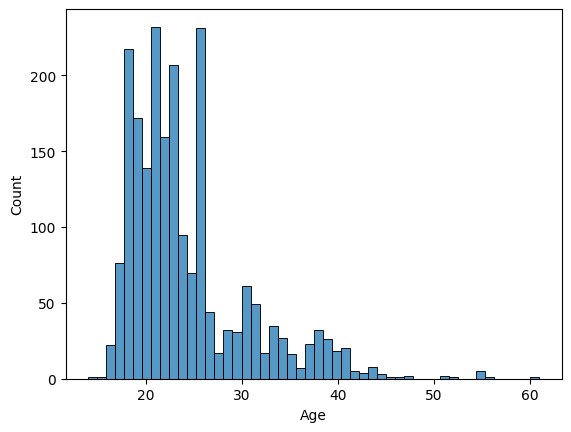

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Plotting a histogram of a numerical column
pdf = df.select('Age').toPandas()
sns.histplot(pdf['Age'])
plt.show()

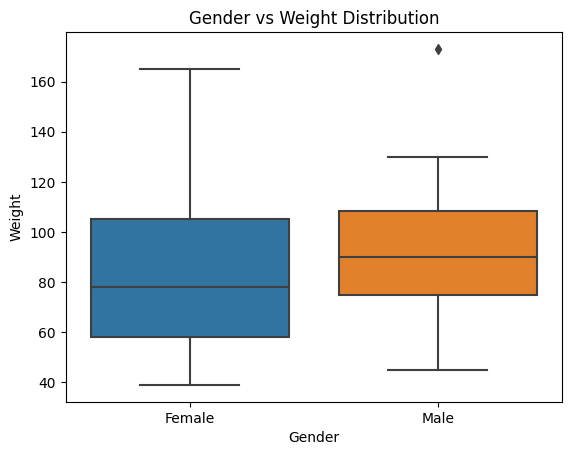

In [20]:
# Box plot for Gender vs Weight

pandas_df = df.toPandas()

sns.boxplot(data=pandas_df, x='Gender', y='Weight')
plt.title('Gender vs Weight Distribution')
plt.show()

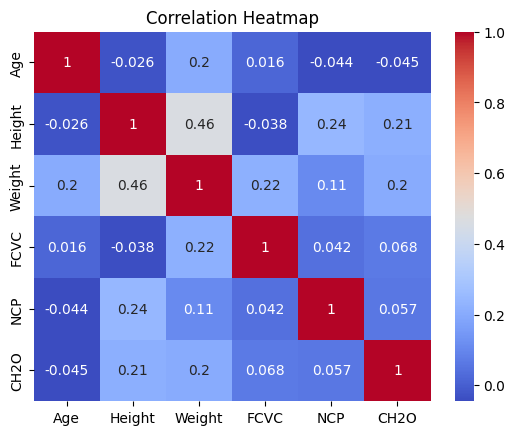

In [21]:
# Assuming you've selected a few relevant continuous features
selected_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O']
corr = pandas_df[selected_features].corr()

# Heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

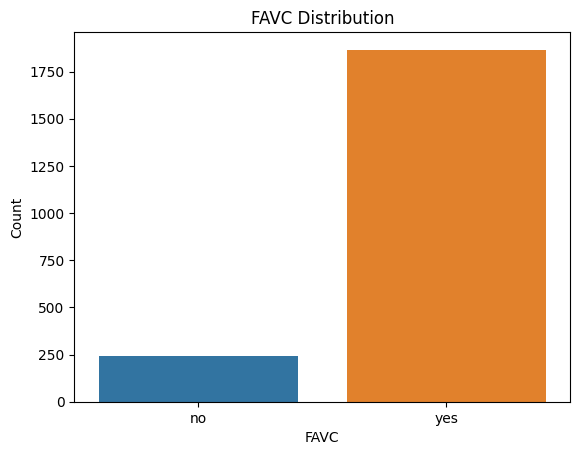

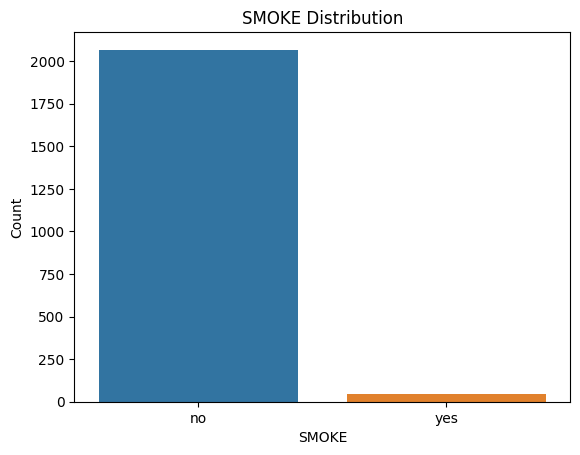

In [22]:
# FAVC Count Plot
sns.countplot(data=pandas_df, x='FAVC')
plt.title('FAVC Distribution')
plt.xlabel('FAVC')
plt.ylabel('Count')
plt.show()

# SMOKE Count Plot
sns.countplot(data=pandas_df, x='SMOKE')
plt.title('SMOKE Distribution')
plt.xlabel('SMOKE')
plt.ylabel('Count')
plt.show()

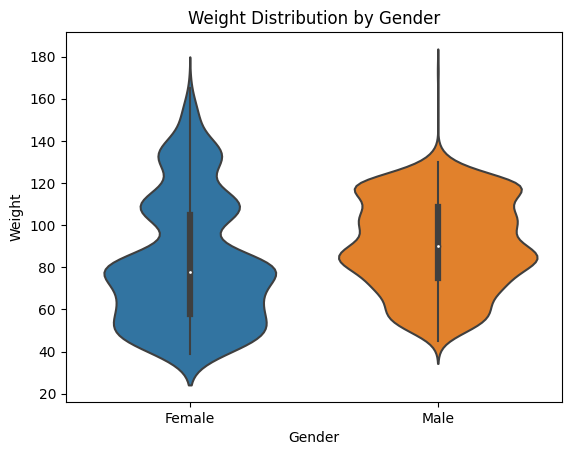

In [23]:
# Distribution of Weight across Gender
sns.violinplot(data=pandas_df, x='Gender', y='Weight')
plt.title('Weight Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Weight')
plt.show()

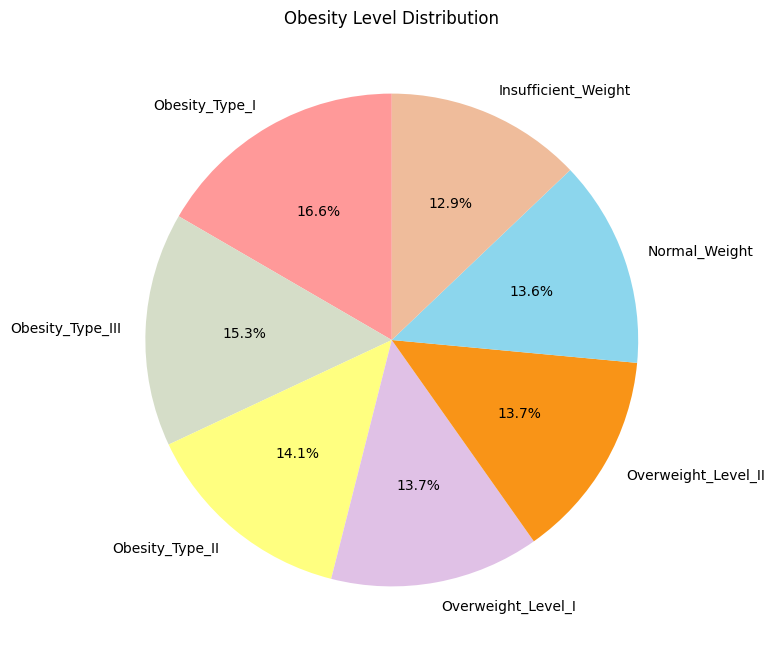

In [24]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
pandas_df = df.toPandas()

custom_colors = ['#ff9999', '#D5DDC8', '#ffff80', '#E0C1E6', '#F99417', '#8CD6ED', '#EFBC9B']

# Pie chart
obesity_levels = pandas_df['NObeyesdad'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(obesity_levels, labels=obesity_levels.index, autopct='%1.1f%%', startangle=90, colors=custom_colors[:len(obesity_levels)])
plt.title('Obesity Level Distribution')
plt.ylabel('')
plt.show()


In [25]:
# Split the data into train and test

train_data, test_data = finalData.randomSplit([0.7, 0.3], seed=42)

In [26]:
test_data.show(n=5)
test_data.printSchema()

+---------------------+--------------+
|Independent_variables|NObeyesdad_idx|
+---------------------+--------------+
| (15,[0,1,2,3,4,5,...|           6.0|
| (15,[0,1,2,3,4,5,...|           6.0|
| (15,[0,1,2,3,4,5,...|           6.0|
| (15,[0,1,2,3,4,5,...|           6.0|
| (15,[0,1,2,3,4,5,...|           6.0|
+---------------------+--------------+
only showing top 5 rows

root
 |-- Independent_variables: vector (nullable = true)
 |-- NObeyesdad_idx: double (nullable = false)



In [27]:
# Initialize Random forest classifier
rf = RandomForestClassifier(labelCol="NObeyesdad_idx", featuresCol="Independent_variables")

In [28]:
# Define the hyperparameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 25]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

# Create the cross-validator
cross_validator = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(labelCol="NObeyesdad_idx", metricName="accuracy"),
                          numFolds=5, seed=42)

# Train the model with the best hyperparameters
cv_model = cross_validator.fit(train_data)

In [29]:
# Feature importance
best_rf_model = cv_model.bestModel
importances = best_rf_model.featureImportances
feature_list = ['Age',
                'BMI',
                'FCVC',
                'NCP',
                'CH2O',
                'FAF',
                'TUE',
                'Gender',
                'family_history_with_overweight',
                'FAVC',
                'CAEC',
                'SMOKE',
                'SCC',
                'CALC',
                'MTRANS']

print("Feature Importances:")
for feature, importance in zip(feature_list, importances):
    print(f"{feature}: {importance:.4f}")

Feature Importances:
Age: 0.0848
BMI: 0.1037
FCVC: 0.0446
NCP: 0.0331
CH2O: 0.0287
FAF: 0.0363
TUE: 0.4582
Gender: 0.0549
family_history_with_overweight: 0.0416
FAVC: 0.0129
CAEC: 0.0376
SMOKE: 0.0015
SCC: 0.0064
CALC: 0.0331
MTRANS: 0.0226


In [30]:
# Make predictions on the test data
predictions = cv_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="NObeyesdad_idx", metricName="accuracy")

# Evaluate the model
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = {:.2f}".format(accuracy))

Test set accuracy = 0.97


In [31]:
# create a feature important scores dataframe for visualization

feature_imp_map = {feature_list[i]: round(importances[i], 4) for i in range(len(feature_list))}
feature_map = [(k,)+(float(v),) for k,v in feature_imp_map.items()]
feature_df = spark.createDataFrame(feature_map, schema=['Features', 'FeatureImpScores'])


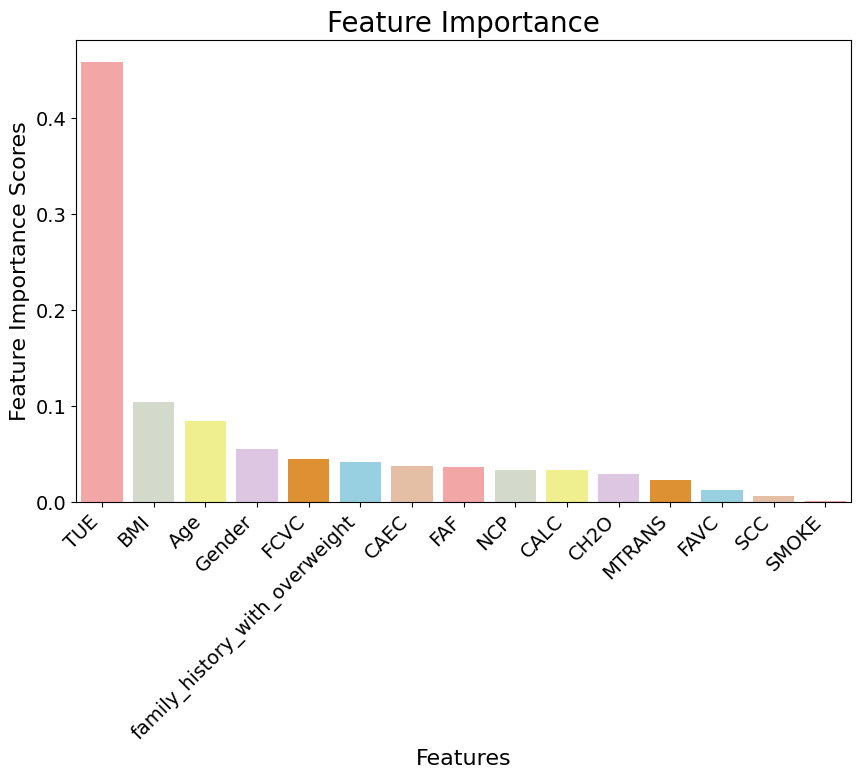

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming feature_df is your Spark DataFrame
# Convert Spark DataFrame to Pandas DataFrame
pyfeature_df = feature_df.toPandas()

# Sort the DataFrame based on 'FeatureImpScores' in descending order
pyfeature_df = pyfeature_df.sort_values(by='FeatureImpScores', ascending=False)

# Custom color palette
custom_colors = ['#ff9999', '#D5DDC8', '#ffff80', '#E0C1E6', '#F99417', '#8CD6ED', '#EFBC9B']

# Plot using Seaborn with the custom colors
plt.figure(figsize=(10, 6))  # Adjust the size as needed
sns.barplot(x='Features', y='FeatureImpScores', data=pyfeature_df, palette=custom_colors)

# Rotate x-labels if necessary
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Feature Importance Scores', fontsize=16)

# Show the plot
plt.show()


In [33]:
# Confusion Matrix
cm_dt_result = predictions.crosstab("prediction", "NObeyesdad_idx")
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result

,prediction_NObeyesdad_idx,0.0,1.0,2.0,3.0,4.0,5.0,6.0
0,0.0,102,0,1,0,0,0,0
1,5.0,0,0,0,0,1,83,5
2,1.0,0,83,0,0,0,0,0
3,6.0,0,0,0,0,0,0,79
4,2.0,0,0,63,0,0,0,0
5,3.0,0,0,0,71,2,4,0
6,4.0,1,0,0,2,79,1,0


In [34]:
def calculate_bmi():
    height = float(input("Enter your height in meters: "))
    weight = float(input("Enter your weight in kilograms: "))
    
    bmi = weight / (height ** 2)
    return bmi

# Calculate and print BMI
BMI = calculate_bmi()
print(f"Your BMI is: {BMI:.2f}")

age = int(input("Enter your age: "))
gender = input("Enter your gender (Male/Female): ")
family_history_with_overweight = input("Do you have a family history of overweight? (yes/no): ")
frequent_consumption_of_high_caloric_food = input("Do you frequently consume high caloric food? (yes/no): ")
frequency_of_consumption_of_vegetables = int(input("Enter the frequency of consumption of vegetables (1-4): "))
number_of_main_meals = int(input("Enter the number of main meals (1-4): "))
consumption_of_food_between_meals = input("Do you consume food between meals? (no/Sometimes/Frequently/Always): ")
smoke = input("Do you smoke? (yes/no): ")
consumption_of_water_daily = int(input("Enter your daily consumption of water (0-3): "))
calories_consumption_monitoring = input("Do you monitor your calorie consumption? (yes/no): ")
physical_activity_frequency = int(input("Enter your physical activity frequency (0-3): "))
time_using_technology_devices = float(input("Enter the time you spend using technology devices (0-3): "))
consumption_of_alcohol = input("Do you consume alcohol? (no/Sometimes/Frequently/Always): ")
transportation_used = input("Enter the mode of transportation you use most (Walking/Public_Transportation/Automobile/Motorbike): ")

Enter your height in meters: 1.80
Enter your weight in kilograms: 100
Your BMI is: 30.86
Enter your age: 30
Enter your gender (Male/Female): Male
Do you have a family history of overweight? (yes/no): yes
Do you frequently consume high caloric food? (yes/no): yes
Enter the frequency of consumption of vegetables (1-4): 2
Enter the number of main meals (1-4): 4
Do you consume food between meals? (no/Sometimes/Frequently/Always): Always
Do you smoke? (yes/no): no
Enter your daily consumption of water (0-3): 2
Do you monitor your calorie consumption? (yes/no): no
Enter your physical activity frequency (0-3): 1
Enter the time you spend using technology devices (0-3): 3
Do you consume alcohol? (no/Sometimes/Frequently/Always): Frequently
Enter the mode of transportation you use most (Walking/Public_Transportation/Automobile/Motorbike): Public_Transportation


In [37]:
from pyspark.ml.linalg import Vectors

new_data = [{
    'Age': age,
    'Gender': gender,
    'BMI': BMI,
    'family_history_with_overweight': family_history_with_overweight,
    'FAVC': frequent_consumption_of_high_caloric_food,
    'FCVC': frequency_of_consumption_of_vegetables,
    'NCP': number_of_main_meals,
    'CAEC': consumption_of_food_between_meals,
    'SMOKE': smoke,
    'CH2O': consumption_of_water_daily,
    'SCC': calories_consumption_monitoring,
    'FAF': physical_activity_frequency,
    'TUE': time_using_technology_devices,
    'CALC': consumption_of_alcohol,
    'MTRANS': transportation_used
}]

In [36]:
# Convert to Spark DataFrame
new_spark_df = spark.createDataFrame(new_data)

# Use the StringIndexer and VectorAssembler from your trained model
new_df_idx = indexer_model.transform(new_spark_df)
new_features = featuresAssembler.transform(new_df_idx)
final_new_data = new_features.selectExpr("Independent_Variables as Independent_variables")

# Make predictions using your trained model
new_predictions = cv_model.transform(final_new_data)

# Show predictions
new_predictions.select("prediction").show()

prediction_index = new_predictions.select("prediction").first()[0]
obesity_classes = {
    0: "Obesity_Type_I",
    1: "Obesity_Type_III",
    2: "Obesity_Type_II",
    3: "Overweight_Level_I",
    4: "Overweight_Level_II",
    5: "Normal_Weight",
    6: "Insufficient_Weight"
}

print(f"Based on the input, the predicted class is: {obesity_classes[prediction_index]}")

+----------+
|prediction|
+----------+
|       0.0|
+----------+

Based on the input, the predicted class is: Obesity_Type_I
